In [1]:
import torch
torch.__version__
torch.cuda.is_available()

True

   location_id                  location_friendlyname location_friendlycode  \
0       138883  Nimble energy - Sokolovska 1. Podzemi              HR050231   
1       138883  Nimble energy - Sokolovska 1. Podzemi              HR050231   
2       138883  Nimble energy - Sokolovska 1. Podzemi              HR050231   
3       138883  Nimble energy - Sokolovska 1. Podzemi              HR050231   
4       138883  Nimble energy - Sokolovska 1. Podzemi              HR050231   

  location_address_cityname location_address_postnumber  \
0                     Praha                      190 00   
1                     Praha                      190 00   
2                     Praha                      190 00   
3                     Praha                      190 00   
4                     Praha                      190 00   

  location_address_streetname location_address_housenumber  \
0                  Sokolovska                       42/217   
1                  Sokolovska                 

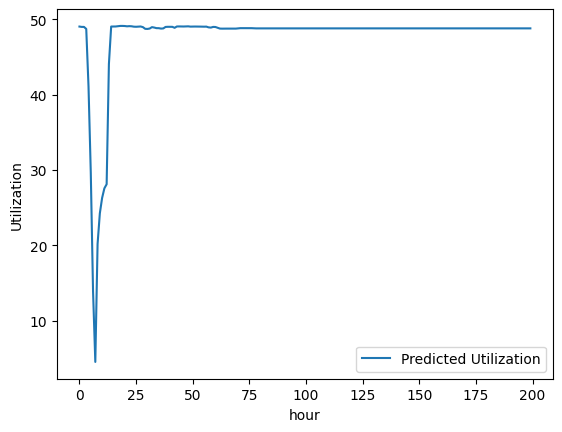

In [1]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader

import psycopg2
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0, c0):
        h0 = torch.zeros(num_layers,  hidden_size).to(device)
        c0 = torch.zeros(num_layers,  hidden_size).to(device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out, (hn, cn)

def expand_data(dataframe):
    '''inputs: original dataframe with values for ONE station'''

    dataframe_copy = dataframe.copy()

    # create new dataframe with index as every hour
    dataframe_copy['Time'] = pd.to_datetime(dataframe_copy['charging_hour'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)

    start_index = dataframe_copy.iloc[0, -1].date() #starting point is the day of the first index
    end_index = dataframe_copy.iloc[-1, -1].date() # ending pojnt is the day of the last index
    indices = pd.date_range(start_index, end_index, freq='1H')

    dataframe_copy.set_index('Time', inplace=True)

    print(dataframe.describe())
    #dataframe.describe().to_csv('Opis podataka Osijek.csv', sep=';')

    # new_dataframe is a dataframe that is expanded with zero values
    new_dataframe = pd.DataFrame(index=indices, data=dataframe_copy)

    # important features (charging_minutes, consumption, utilization) are filled with zeros
    # other values (that are the same for each time step) are copied - like connector_count and location_accesstype
    #new_dataframe['location_accesstype_title'] = new_dataframe['location_accesstype_title'].fillna(dataframe_copy['location_accesstype_title'][0])
    new_dataframe['charging_hour'] = new_dataframe['charging_hour'].fillna(np.nan)
    # charging_hour column is filled with Nan values because it will be later dropped and is not necessary
    new_dataframe['utilization'] = new_dataframe['utilization'].fillna(0.0)
    #new_dataframe['connector_count'] = new_dataframe['connector_count'].fillna(dataframe_copy['connector_count'][0])
    #new_dataframe['congested_connectors'] = new_dataframe['congested_connectors'].fillna(0.0)
    #new_dataframe['energy_consumption'] = new_dataframe['energy_consumption'].fillna(0.0)
    #new_dataframe['charging_minutes'] = new_dataframe['charging_minutes'].fillna(0.0)

    # new_dataframe is then save to the .csv file
    # new_dataframe.to_csv(r'C:\Users\ZVNE\OneDrive - fer.hr\projekti\E-Mobility Grčka\station data expanded ' + str(name) + '.csv', sep=';')

    # expanded dataframe is returned
    return new_dataframe

from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    #df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'util(t-{i})'] = df['utilization'].shift(i)

    #df.dropna(inplace=True)

    return df


import psycopg2

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host="34.171.207.247",
    database="localai",
    user="postgres",
    password="pglocalai"
)

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Execute a SELECT query to fetch data from a table
query = "SELECT * FROM ht_cpn_station_data_hour WHERE location_id = 138883"
cursor.execute(query)

# Fetch all rows from the result set
rows = cursor.fetchall()

# Get the column names from the cursor description
columns = [desc[0] for desc in cursor.description]

# Create a Pandas DataFrame with the fetched data and column names
df = pd.DataFrame(rows, columns=columns)

# Close the cursor and connection
cursor.close()
conn.close()

# Print the DataFrame
print(df.head())




# Read the data from CSV
#data = pd.read_csv("station_data_hour_Opatija.csv")


# Provide the dataframe from database
data_station = df.copy()

# Get the user-provided value to filter on

data_station = data_station[["utilization","charging_hour"]]
data_station


expanded_data_op = expand_data(data_station)
expanded_data_op

filter_data = expanded_data_op.copy() # here we selected which of the three stations is used


lookback = 64
shifted_df = prepare_dataframe_for_lstm(filter_data, lookback)
shifted_df

for i in range(1, lookback+1):
  shifted_df[f'util(t-{i})'] = shifted_df[f'util(t-{i})'].fillna(0.0)

shifted_df = shifted_df.drop(columns = "charging_hour", axis = 1)

shifted_df_as_np = shifted_df.to_numpy()

X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X = dc(np.flip(X, axis=1))

#X = X[len(X)//2:]
#y = y[len(X)//2:]

train_size = int(len(filter_data) * 0.8)
val_size = int(len(filter_data) * 0.1)
test_size = len(filter_data) - train_size - val_size

X_train = X[:train_size]
X_val = X[train_size:train_size+val_size]
X_test = X[train_size+ val_size:]

y_train = y[:train_size]
y_val = y[train_size:train_size+val_size]
y_test = y[train_size+ val_size:]

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

X_train = X_train.reshape((-1, lookback))
X_val = X_val.reshape((-1, lookback))
X_test = X_test.reshape((-1, lookback))

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_dataset.X.size(1)  # Number of features in the input data
hidden_size = 250  # Number of units in the LSTM hidden layer
num_layers = 4  # Number of LSTM layers
output_size = 1  # Number of output features (energy consumption and utilization)
learning_rate = 0.0005
num_epochs = 150
batch_size = 64

# Create data loaders

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize hidden states and cell states on the specified device
h0 = torch.zeros(num_layers,  hidden_size).to(device)
c0 = torch.zeros(num_layers,  hidden_size).to(device)

# Placeholder for the best validation accuracy
best_val_loss = float('inf')  # Initialize with a large value
best_model_state = None

# Training loop
for epoch in range(num_epochs):
    h0 = torch.zeros(num_layers,  hidden_size).to(device)
    c0 = torch.zeros(num_layers,  hidden_size).to(device)
    model.train()
    total_loss = 0
    for batch_idx, (features, labels) in enumerate(train_loader):

        features, labels = features.to(device), labels.to(device)  # Move data to the specified device
        h0 = h0.to(device)
        c0 = c0.to(device)
        # Forward pass with hidden states
        #print(features.shape)
        outputs, (h0, c0) = model(features, h0.detach(), c0.detach())
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    predictions = []
    with torch.no_grad():
        # Initialize validation hidden states and cell states with the final states of the training set
        h0_val = h0.detach().clone()
        c0_val = c0.detach().clone()

        for batch_idx, (features, labels) in enumerate(val_loader):
            features, labels = features.to(device), labels.to(device)

            # Forward pass with hidden states
            outputs, (h0_val, c0_val) = model(features, h0_val, c0_val)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # store predictions
            predictions.extend(outputs.cpu().numpy())

    average_val_loss = val_loss / len(val_loader)
    # keep the model with the best performance in the validation set
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_model_state = model.state_dict()
        best_predictions = predictions

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}')

print('Training finished.')
print(best_val_loss)

model.load_state_dict(best_model_state)

# Save the best predictions for plotting (optional, you can save them for future use)
np.save('best_predictions.npy', np.array(best_predictions))


with torch.no_grad():
    predicted, (h0_val,c0_val) = model(X_test.to(device),h0_val, c0_val)
    #print((h0_val,c0_val))


new_in = predicted[-65:-1]
new_in = torch.unsqueeze(torch.squeeze(new_in, 1),0)
predicted, (h0_val,c0_val) = model(new_in,h0_val, c0_val)
new_in = torch.cat((new_in,predicted),1)
new_in = new_in[0][1:]
new_in = torch.unsqueeze(new_in,0)

predictions = []
for i in range(200):
  predicted, (h0_val,c0_val) = model(new_in,h0_val, c0_val)
  new_in = torch.cat((new_in,predicted),1)
  new_in = new_in[0][1:]
  new_in = torch.unsqueeze(new_in,0)
  predictions.append(predicted.item())


plt.plot(np.array(predictions), label='Predicted Utilization')
plt.xlabel('hour')
plt.ylabel('Utilization')
plt.legend()
plt.show()


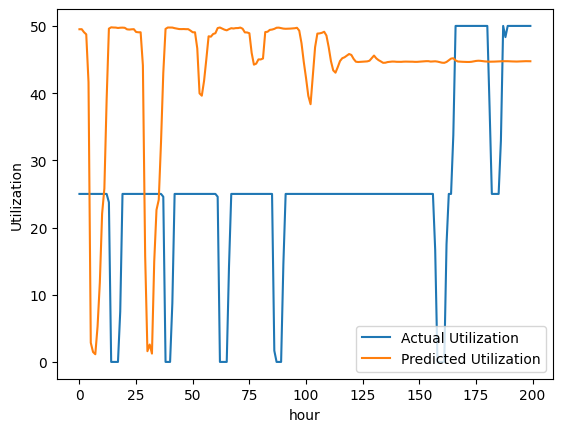

In [4]:
plt.plot(np.array(y_test[-201:-1]), label='Actual Utilization')
plt.plot(np.array(predictions), label='Predicted Utilization')
plt.xlabel('hour')
plt.ylabel('Utilization')
plt.legend()
plt.show()

   location_id                  location_friendlyname location_friendlycode  \
0       138883  Nimble energy - Sokolovska 1. Podzemi              HR050231   
1       138883  Nimble energy - Sokolovska 1. Podzemi              HR050231   
2       138883  Nimble energy - Sokolovska 1. Podzemi              HR050231   
3       138883  Nimble energy - Sokolovska 1. Podzemi              HR050231   
4       138883  Nimble energy - Sokolovska 1. Podzemi              HR050231   

  location_address_cityname location_address_postnumber  \
0                     Praha                      190 00   
1                     Praha                      190 00   
2                     Praha                      190 00   
3                     Praha                      190 00   
4                     Praha                      190 00   

  location_address_streetname location_address_housenumber  \
0                  Sokolovska                       42/217   
1                  Sokolovska                 

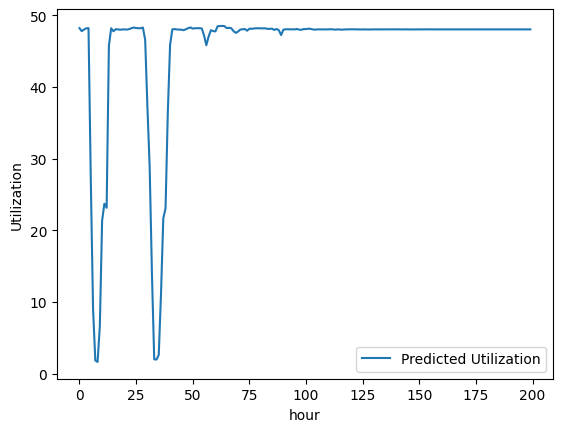

In [26]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader

import psycopg2
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0, c0):
        h0 = torch.zeros(num_layers,  hidden_size).to(device)
        c0 = torch.zeros(num_layers,  hidden_size).to(device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out, (hn, cn)

def expand_data(dataframe):
    '''inputs: original dataframe with values for ONE station'''

    dataframe_copy = dataframe.copy()

    # create new dataframe with index as every hour
    dataframe_copy['Time'] = pd.to_datetime(dataframe_copy['charging_hour'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)

    start_index = dataframe_copy.iloc[0, -1].date() #starting point is the day of the first index
    end_index = dataframe_copy.iloc[-1, -1].date() # ending pojnt is the day of the last index
    indices = pd.date_range(start_index, end_index, freq='1H')

    dataframe_copy.set_index('Time', inplace=True)

    print(dataframe.describe())
    #dataframe.describe().to_csv('Opis podataka Osijek.csv', sep=';')

    # new_dataframe is a dataframe that is expanded with zero values
    new_dataframe = pd.DataFrame(index=indices, data=dataframe_copy)

    # important features (charging_minutes, consumption, utilization) are filled with zeros
    # other values (that are the same for each time step) are copied - like connector_count and location_accesstype
    #new_dataframe['location_accesstype_title'] = new_dataframe['location_accesstype_title'].fillna(dataframe_copy['location_accesstype_title'][0])
    new_dataframe['charging_hour'] = new_dataframe['charging_hour'].fillna(np.nan)
    # charging_hour column is filled with Nan values because it will be later dropped and is not necessary
    new_dataframe['utilization'] = new_dataframe['utilization'].fillna(0.0)
    #new_dataframe['connector_count'] = new_dataframe['connector_count'].fillna(dataframe_copy['connector_count'][0])
    #new_dataframe['congested_connectors'] = new_dataframe['congested_connectors'].fillna(0.0)
    #new_dataframe['energy_consumption'] = new_dataframe['energy_consumption'].fillna(0.0)
    #new_dataframe['charging_minutes'] = new_dataframe['charging_minutes'].fillna(0.0)

    # new_dataframe is then save to the .csv file
    # new_dataframe.to_csv(r'C:\Users\ZVNE\OneDrive - fer.hr\projekti\E-Mobility Grčka\station data expanded ' + str(name) + '.csv', sep=';')

    # expanded dataframe is returned
    return new_dataframe

from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    #df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'util(t-{i})'] = df['utilization'].shift(i)

    #df.dropna(inplace=True)

    return df


import psycopg2

# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host="34.171.207.247",
    database="localai",
    user="postgres",
    password="pglocalai"
)

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Execute a SELECT query to fetch data from a table
query = "SELECT * FROM ht_cpn_station_data_hour WHERE location_id = 138883"
cursor.execute(query)

# Fetch all rows from the result set
rows = cursor.fetchall()

# Get the column names from the cursor description
columns = [desc[0] for desc in cursor.description]

# Create a Pandas DataFrame with the fetched data and column names
df = pd.DataFrame(rows, columns=columns)

# Close the cursor and connection
cursor.close()
conn.close()

# Print the DataFrame
print(df.head())




# Read the data from CSV
#data = pd.read_csv("station_data_hour_Opatija.csv")


# Provide the dataframe from database
data_station = df.copy()

# Get the user-provided value to filter on

data_station = data_station[["utilization","charging_hour"]]
data_station


expanded_data_op = expand_data(data_station)
expanded_data_op

filter_data = expanded_data_op.copy() # here we selected which of the three stations is used


lookback = 64
shifted_df = prepare_dataframe_for_lstm(filter_data, lookback)
shifted_df

for i in range(1, lookback+1):
  shifted_df[f'util(t-{i})'] = shifted_df[f'util(t-{i})'].fillna(0.0)

shifted_df = shifted_df.drop(columns = "charging_hour", axis = 1)

shifted_df_as_np = shifted_df.to_numpy()

X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X = dc(np.flip(X, axis=1))

#X = X[len(X)//2:]
#y = y[len(X)//2:]

train_size = int(len(filter_data) * 0.8)
val_size = int(len(filter_data) * 0.1)
test_size = len(filter_data) - train_size - val_size

X_train = X[:train_size]
X_val = X[train_size:train_size+val_size]
X_test = X[train_size+ val_size:]

y_train = y[:train_size]
y_val = y[train_size:train_size+val_size]
y_test = y[train_size+ val_size:]

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

X_train = X_train.reshape((-1, lookback))
X_val = X_val.reshape((-1, lookback))
X_test = X_test.reshape((-1, lookback))

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_dataset.X.size(1)  # Number of features in the input data
hidden_size = 250  # Number of units in the LSTM hidden layer
num_layers = 4  # Number of LSTM layers
output_size = 1  # Number of output features (energy consumption and utilization)
learning_rate = 0.0005
num_epochs = 80
batch_size = 64

# Create data loaders

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize hidden states and cell states on the specified device
h0 = torch.zeros(num_layers,  hidden_size).to(device)
c0 = torch.zeros(num_layers,  hidden_size).to(device)

# Placeholder for the best validation accuracy
best_val_loss = float('inf')  # Initialize with a large value
best_model_state = None

# Training loop
for epoch in range(num_epochs):
    h0 = torch.zeros(num_layers,  hidden_size).to(device)
    c0 = torch.zeros(num_layers,  hidden_size).to(device)
    model.train()
    total_loss = 0
    for batch_idx, (features, labels) in enumerate(train_loader):

        features, labels = features.to(device), labels.to(device)  # Move data to the specified device
        h0 = h0.to(device)
        c0 = c0.to(device)
        # Forward pass with hidden states
        #print(features.shape)
        outputs, (h0, c0) = model(features, h0.detach(), c0.detach())
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    predictions = []
    with torch.no_grad():
        # Initialize validation hidden states and cell states with the final states of the training set
        h0_val = h0.detach().clone()
        c0_val = c0.detach().clone()

        for batch_idx, (features, labels) in enumerate(val_loader):
            features, labels = features.to(device), labels.to(device)

            # Forward pass with hidden states
            outputs, (h0_val, c0_val) = model(features, h0_val, c0_val)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # store predictions
            predictions.extend(outputs.cpu().numpy())

    average_val_loss = val_loss / len(val_loader)
    # keep the model with the best performance in the validation set
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_model_state = model.state_dict()
        best_predictions = predictions

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}')

print('Training finished.')
print(best_val_loss)

model.load_state_dict(best_model_state)

# Save the best predictions for plotting (optional, you can save them for future use)
np.save('best_predictions.npy', np.array(best_predictions))


with torch.no_grad():
    predicted, (h0_val,c0_val) = model(X_test.to(device),h0_val, c0_val)
    #print((h0_val,c0_val))


new_in = predicted[-65:-1]
new_in = torch.unsqueeze(torch.squeeze(new_in, 1),0)
predicted, (h0_val,c0_val) = model(new_in,h0_val, c0_val)
new_in = torch.cat((new_in,predicted),1)
new_in = new_in[0][1:]
new_in = torch.unsqueeze(new_in,0)

predictions = []
for i in range(200):
  predicted, (h0_val,c0_val) = model(new_in,h0_val, c0_val)
  new_in = torch.cat((new_in,predicted),1)
  new_in = new_in[0][1:]
  new_in = torch.unsqueeze(new_in,0)
  predictions.append(predicted.item())


plt.plot(np.array(predictions), label='Predicted Utilization')
plt.xlabel('hour')
plt.ylabel('Utilization')
plt.legend()
plt.show()


In [15]:
X = X[len(X)//2:]

21385

In [16]:
len(X[len(X)//2:])

10693

       utilization
count  1627.000000
mean     42.302295
std      21.296356
min       0.000000
25%      27.500000
50%      50.000000
75%      50.000000
max     100.000000
128
128
Epoch [1/150], Train Loss: 344.3165, Validation Loss: 337.1746
Epoch [2/150], Train Loss: 337.5009, Validation Loss: 336.8491
Epoch [3/150], Train Loss: 336.5333, Validation Loss: 328.9157
Epoch [4/150], Train Loss: 264.5402, Validation Loss: 200.2172
Epoch [5/150], Train Loss: 174.6034, Validation Loss: 142.4882
Epoch [6/150], Train Loss: 141.1047, Validation Loss: 119.4527
Epoch [7/150], Train Loss: 119.3126, Validation Loss: 105.3172
Epoch [8/150], Train Loss: 107.4955, Validation Loss: 96.8116
Epoch [9/150], Train Loss: 99.0273, Validation Loss: 86.3165
Epoch [10/150], Train Loss: 90.3174, Validation Loss: 83.5317
Epoch [11/150], Train Loss: 84.5714, Validation Loss: 77.0704
Epoch [12/150], Train Loss: 82.4612, Validation Loss: 74.8182
Epoch [13/150], Train Loss: 77.6859, Validation Loss: 75.2845
Epoch [14

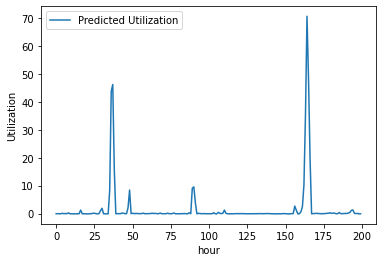

'\nprint(predicted.shape)\nplt.plot(np.array(y_test), label=\'Actual Close\')\nplt.plot((predicted.cpu()), label=\'Predicted Close\')\nplt.xlabel(\'Day\')\nplt.ylabel(\'Close\')\nplt.legend()\nplt.show()\n\n\n# Plot the best predictions for "energy consumption" and "utilization" separately\nfig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)\n\n# Plot "energy consumption" predictions\nax1.plot(np.array(best_predictions)[:, 0], label=\'Utilization (Predicted)\', color=\'orange\')\nax1.plot(val_dataset.y.numpy()[:, 0], label=\'Utilization (True)\', color=\'blue\')\nax1.set_ylabel(\'Utilization\')\nax1.legend()\n\n\nplt.xlabel(\'Time Step\')\nplt.show()\n\n'

In [10]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader

import psycopg2
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0, c0):
        h0 = torch.zeros(num_layers,  hidden_size).to(device)
        c0 = torch.zeros(num_layers,  hidden_size).to(device)
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out)
        return out, (hn, cn)

def expand_data(dataframe):
    '''inputs: original dataframe with values for ONE station'''

    dataframe_copy = dataframe.copy()

    # create new dataframe with index as every hour
    dataframe_copy['Time'] = pd.to_datetime(dataframe_copy['charging_hour'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)

    start_index = dataframe_copy.iloc[0, -1].date() #starting point is the day of the first index
    end_index = dataframe_copy.iloc[-1, -1].date() # ending pojnt is the day of the last index
    indices = pd.date_range(start_index, end_index, freq='1H')

    dataframe_copy.set_index('Time', inplace=True)

    print(dataframe.describe())
    #dataframe.describe().to_csv('Opis podataka Osijek.csv', sep=';')

    # new_dataframe is a dataframe that is expanded with zero values
    new_dataframe = pd.DataFrame(index=indices, data=dataframe_copy)

    # important features (charging_minutes, consumption, utilization) are filled with zeros
    # other values (that are the same for each time step) are copied - like connector_count and location_accesstype
    #new_dataframe['location_accesstype_title'] = new_dataframe['location_accesstype_title'].fillna(dataframe_copy['location_accesstype_title'][0])
    new_dataframe['charging_hour'] = new_dataframe['charging_hour'].fillna(np.nan)
    # charging_hour column is filled with Nan values because it will be later dropped and is not necessary
    new_dataframe['utilization'] = new_dataframe['utilization'].fillna(0.0)
    #new_dataframe['connector_count'] = new_dataframe['connector_count'].fillna(dataframe_copy['connector_count'][0])
    #new_dataframe['congested_connectors'] = new_dataframe['congested_connectors'].fillna(0.0)
    #new_dataframe['energy_consumption'] = new_dataframe['energy_consumption'].fillna(0.0)
    #new_dataframe['charging_minutes'] = new_dataframe['charging_minutes'].fillna(0.0)

    # new_dataframe is then save to the .csv file
    # new_dataframe.to_csv(r'C:\Users\ZVNE\OneDrive - fer.hr\projekti\E-Mobility Grčka\station data expanded ' + str(name) + '.csv', sep=';')

    # expanded dataframe is returned
    return new_dataframe

from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    #df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'util(t-{i})'] = df['utilization'].shift(i)

    #df.dropna(inplace=True)

    return df


import psycopg2
'''
# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host="34.171.207.247",
    database="localai",
    user="postgres",
    password="pglocalai"
)

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Execute a SELECT query to fetch data from a table
query = "SELECT * FROM ht_cpn_station_data_hour WHERE location_id = 138883"
cursor.execute(query)

# Fetch all rows from the result set
rows = cursor.fetchall()

# Get the column names from the cursor description
columns = [desc[0] for desc in cursor.description]

# Create a Pandas DataFrame with the fetched data and column names
df = pd.DataFrame(rows, columns=columns)

# Close the cursor and connection
cursor.close()
conn.close()

# Print the DataFrame
print(df.head())

'''


# Read the data from CSV
data = pd.read_csv("station_data_hour_Opatija.csv")


# Provide the dataframe from database
data_station = data.copy()

# Get the user-provided value to filter on

data_station = data_station[["utilization","charging_hour"]]
data_station


expanded_data_op = expand_data(data_station)
expanded_data_op

filter_data = expanded_data_op.copy() # here we selected which of the three stations is used


lookback = 128
shifted_df = prepare_dataframe_for_lstm(filter_data, lookback)
shifted_df

for i in range(1, lookback+1):
  shifted_df[f'util(t-{i})'] = shifted_df[f'util(t-{i})'].fillna(0.0)

shifted_df = shifted_df.drop(columns = "charging_hour", axis = 1)

shifted_df_as_np = shifted_df.to_numpy()

X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X = dc(np.flip(X, axis=1))
X[0]

train_size = int(len(filter_data) * 0.8)
val_size = int(len(filter_data) * 0.1)
test_size = len(filter_data) - train_size - val_size

X_train = X[:train_size]
X_val = X[train_size:train_size+val_size]
X_test = X[train_size+ val_size:]

y_train = y[:train_size]
y_val = y[train_size:train_size+val_size]
y_test = y[train_size+ val_size:]

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

X_train = X_train.reshape((-1, lookback))
X_val = X_val.reshape((-1, lookback))
X_test = X_test.reshape((-1, lookback))

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_dataset.X.size(1)  # Number of features in the input data
hidden_size = 250  # Number of units in the LSTM hidden layer
num_layers = 4  # Number of LSTM layers
output_size = 1  # Number of output features (energy consumption and utilization)
learning_rate = 0.0005
num_epochs = 150
batch_size = 128

print(input_size)
# Create data loaders

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize hidden states and cell states on the specified device
h0 = torch.zeros(num_layers,  hidden_size).to(device)
c0 = torch.zeros(num_layers,  hidden_size).to(device)

# Placeholder for the best validation accuracy
best_val_loss = float('inf')  # Initialize with a large value
best_model_state = None
print(input_size)
# Training loop
for epoch in range(num_epochs):
    h0 = torch.zeros(num_layers,  hidden_size).to(device)
    c0 = torch.zeros(num_layers,  hidden_size).to(device)
    model.train()
    total_loss = 0
    for batch_idx, (features, labels) in enumerate(train_loader):

        features, labels = features.to(device), labels.to(device)  # Move data to the specified device
        h0 = h0.to(device)
        c0 = c0.to(device)
        # Forward pass with hidden states
        #print(features.shape)
        outputs, (h0, c0) = model(features, h0.detach(), c0.detach())
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    predictions = []
    with torch.no_grad():
        # Initialize validation hidden states and cell states with the final states of the training set
        h0_val = h0.detach().clone()
        c0_val = c0.detach().clone()

        for batch_idx, (features, labels) in enumerate(val_loader):
            features, labels = features.to(device), labels.to(device)

            # Forward pass with hidden states
            outputs, (h0_val, c0_val) = model(features, h0_val, c0_val)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # store predictions
            predictions.extend(outputs.cpu().numpy())

    average_val_loss = val_loss / len(val_loader)
    # keep the model with the best performance in the validation set
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_model_state = model.state_dict()
        best_predictions = predictions

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}')

print('Training finished.')
print(best_val_loss)

model.load_state_dict(best_model_state)

# Save the best predictions for plotting (optional, you can save them for future use)
np.save('best_predictions.npy', np.array(best_predictions))


with torch.no_grad():
    predicted, (h0_val,c0_val) = model(X_test.to(device),h0_val, c0_val)
    #print((h0_val,c0_val))


new_in = predicted[-129:-1]
new_in = torch.unsqueeze(torch.squeeze(new_in, 1),0)
predicted, (h0_val,c0_val) = model(new_in,h0_val, c0_val)
new_in = torch.cat((new_in,predicted),1)
new_in = new_in[0][1:]
new_in = torch.unsqueeze(new_in,0)

predictions = []
for i in range(200):
  predicted, (h0_val,c0_val) = model(new_in,h0_val, c0_val)
  new_in = torch.cat((new_in,predicted),1)
  new_in = new_in[0][1:]
  new_in = torch.unsqueeze(new_in,0)
  predictions.append(predicted.item())


plt.plot(np.array(predictions), label='Predicted Utilization')
plt.xlabel('hour')
plt.ylabel('Utilization')
plt.legend()
plt.show()

'''
print(predicted.shape)
plt.plot(np.array(y_test), label='Actual Close')
plt.plot((predicted.cpu()), label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


# Plot the best predictions for "energy consumption" and "utilization" separately
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot "energy consumption" predictions
ax1.plot(np.array(best_predictions)[:, 0], label='Utilization (Predicted)', color='orange')
ax1.plot(val_dataset.y.numpy()[:, 0], label='Utilization (True)', color='blue')
ax1.set_ylabel('Utilization')
ax1.legend()


plt.xlabel('Time Step')
plt.show()

'''


In [8]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader

import psycopg2
from torch.utils.data import Dataset


class CustomDataset(Dataset):
    def __init__(self, seq_len=5, max_len=1000, seq = []):
        super(CustomDataset).__init__()
        self.datalist = seq
        self.data, self.targets = self.timeseries(self.datalist, seq_len)

    def __len__(self):
        return len(self.data)

    def timeseries(self, data, window):
        temp = []
        targ = data[window:]
        for i in range(len(data)-window):
            temp.append(data[i:i+window])

        return np.array(temp), targ

    def __getitem__(self, index):
        x = torch.tensor(self.data[index]).type(torch.Tensor)
        y = torch.tensor(self.targets[index]).type(torch.Tensor)
        return x,y


class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        #h0 = torch.zeros(num_layers,  hidden_size).to(device)
        #c0 = torch.zeros(num_layers,  hidden_size).to(device)
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

def expand_data(dataframe):
    '''inputs: original dataframe with values for ONE station'''

    dataframe_copy = dataframe.copy()

    # create new dataframe with index as every hour
    dataframe_copy['Time'] = pd.to_datetime(dataframe_copy['charging_hour'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize(None)

    start_index = dataframe_copy.iloc[0, -1].date() #starting point is the day of the first index
    end_index = dataframe_copy.iloc[-1, -1].date() # ending pojnt is the day of the last index
    indices = pd.date_range(start_index, end_index, freq='1H')

    dataframe_copy.set_index('Time', inplace=True)

    print(dataframe.describe())
    #dataframe.describe().to_csv('Opis podataka Osijek.csv', sep=';')

    # new_dataframe is a dataframe that is expanded with zero values
    new_dataframe = pd.DataFrame(index=indices, data=dataframe_copy)

    # important features (charging_minutes, consumption, utilization) are filled with zeros
    # other values (that are the same for each time step) are copied - like connector_count and location_accesstype
    #new_dataframe['location_accesstype_title'] = new_dataframe['location_accesstype_title'].fillna(dataframe_copy['location_accesstype_title'][0])
    new_dataframe['charging_hour'] = new_dataframe['charging_hour'].fillna(np.nan)
    # charging_hour column is filled with Nan values because it will be later dropped and is not necessary
    new_dataframe['utilization'] = new_dataframe['utilization'].fillna(0.0)
    #new_dataframe['connector_count'] = new_dataframe['connector_count'].fillna(dataframe_copy['connector_count'][0])
    #new_dataframe['congested_connectors'] = new_dataframe['congested_connectors'].fillna(0.0)
    #new_dataframe['energy_consumption'] = new_dataframe['energy_consumption'].fillna(0.0)
    #new_dataframe['charging_minutes'] = new_dataframe['charging_minutes'].fillna(0.0)

    # new_dataframe is then save to the .csv file
    # new_dataframe.to_csv(r'C:\Users\ZVNE\OneDrive - fer.hr\projekti\E-Mobility Grčka\station data expanded ' + str(name) + '.csv', sep=';')

    # expanded dataframe is returned
    return new_dataframe

from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)

    #df.set_index('Date', inplace=True)

    for i in range(1, n_steps+1):
        df[f'util(t-{i})'] = df['utilization'].shift(i)

    #df.dropna(inplace=True)

    return df


import psycopg2
'''
# Connect to the PostgreSQL database
conn = psycopg2.connect(
    host="34.171.207.247",
    database="localai",
    user="postgres",
    password="pglocalai"
)

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Execute a SELECT query to fetch data from a table
query = "SELECT * FROM ht_cpn_station_data_hour WHERE location_id = 138883"
cursor.execute(query)

# Fetch all rows from the result set
rows = cursor.fetchall()

# Get the column names from the cursor description
columns = [desc[0] for desc in cursor.description]

# Create a Pandas DataFrame with the fetched data and column names
df = pd.DataFrame(rows, columns=columns)

# Close the cursor and connection
cursor.close()
conn.close()

# Print the DataFrame
print(df.head())

'''

class CustomDataset(Dataset):
    def __init__(self, seq_len=5, max_len=1000, seq = []):
        super(CustomDataset).__init__()
        self.datalist = seq
        self.data, self.targets = self.timeseries(self.datalist, seq_len)

    def __len__(self):
        return len(self.data)

    def timeseries(self, data, window):
        temp = []
        targ = data[window:]
        for i in range(len(data)-window):
            temp.append(data[i:i+window])

        return np.array(temp), targ

    def __getitem__(self, index):
        x = torch.tensor(self.data[index]).type(torch.Tensor)
        y = torch.tensor(self.targets[index]).type(torch.Tensor)
        return x,y



# Read the data from CSV
data = pd.read_csv("station_data_hour_Opatija.csv")


# Provide the dataframe from database
data_station = data.copy()

# Get the user-provided value to filter on

data_station = data_station[["utilization","charging_hour"]]
data_station


expanded_data_op = expand_data(data_station)
expanded_data_op

filter_data = expanded_data_op.copy() # here we selected which of the three stations is used


lookback = 128
shifted_df = prepare_dataframe_for_lstm(filter_data, lookback)
shifted_df

for i in range(1, lookback+1):
  shifted_df[f'util(t-{i})'] = shifted_df[f'util(t-{i})'].fillna(0.0)

shifted_df = shifted_df.drop(columns = "charging_hour", axis = 1)

shifted_df_as_np = shifted_df.to_numpy()

X = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

X = dc(np.flip(X, axis=1))
X[0]

train_size = int(len(filter_data) * 0.8)
val_size = int(len(filter_data) * 0.1)
test_size = len(filter_data) - train_size - val_size

X_train = X[:train_size]
X_val = X[train_size:train_size+val_size]
X_test = X[train_size+ val_size:]



train_dataset = CustomDataset(seq_len=128, max_len=len(X_train), seq = X_train)
val_dataset = CustomDataset(seq_len=128, max_len=len(X_val), seq = X_val)
test_dataset = CustomDataset(seq_len=128, max_len=len(X_test), seq = X_test)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


"""
y_train = y[:train_size]
y_val = y[train_size:train_size+val_size]
y_test = y[train_size+ val_size:]

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

X_train = X_train.reshape((-1, lookback))
X_val = X_val.reshape((-1, lookback))
X_test = X_test.reshape((-1, lookback))

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_val = torch.tensor(X_val).float()
y_val = torch.tensor(y_val).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

train_dataset = TimeSeriesDataset(X_train, y_train)
val_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

"""

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = train_dataset.X.size(1)  # Number of features in the input data
hidden_size = 250  # Number of units in the LSTM hidden layer
num_layers = 4  # Number of LSTM layers
output_size = 1  # Number of output features (energy consumption and utilization)
learning_rate = 0.0005
num_epochs = 150
batch_size = 128

# Create data loaders

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Initialize hidden states and cell states on the specified device
#h0 = torch.zeros(num_layers,  hidden_size).to(device)
#c0 = torch.zeros(num_layers,  hidden_size).to(device)

# Placeholder for the best validation accuracy
best_val_loss = float('inf')  # Initialize with a large value
best_model_state = None

# Training loop
for epoch in range(num_epochs):
    #h0 = torch.zeros(num_layers,  hidden_size).to(device)
    #c0 = torch.zeros(num_layers,  hidden_size).to(device)
    model.train()
    total_loss = 0
    for batch_idx, (features, labels) in enumerate(train_loader):

        features, labels = features.to(device), labels.to(device)  # Move data to the specified device
        #h0 = h0.to(device)
        #c0 = c0.to(device)
        # Forward pass with hidden states
        #print(features.shape)
        outputs = model(features)
        loss = criterion(outputs, labels)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_train_loss = total_loss / len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    predictions = []
    with torch.no_grad():
        # Initialize validation hidden states and cell states with the final states of the training set
        #h0_val = h0.detach().clone()
        #c0_val = c0.detach().clone()

        for batch_idx, (features, labels) in enumerate(val_loader):
            features, labels = features.to(device), labels.to(device)

            # Forward pass with hidden states
            outputs = model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # store predictions
            predictions.extend(outputs.cpu().numpy())

    average_val_loss = val_loss / len(val_loader)
    # keep the model with the best performance in the validation set
    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_model_state = model.state_dict()
        best_predictions = predictions

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}')

print('Training finished.')
print(best_val_loss)

model.load_state_dict(best_model_state)

# Save the best predictions for plotting (optional, you can save them for future use)
np.save('best_predictions.npy', np.array(best_predictions))


with torch.no_grad():
    predicted, (h0_val,c0_val) = model(X_test.to(device),h0_val, c0_val)
    #print((h0_val,c0_val))


new_in = predicted[-129:-1]
new_in = torch.unsqueeze(torch.squeeze(new_in, 1),0)
predicted = model(new_in)
new_in = torch.cat((new_in,predicted),1)
new_in = new_in[0][1:]
new_in = torch.unsqueeze(new_in,0)

predictions = []
for i in range(200):
  predicted = model(new_in)
  new_in = torch.cat((new_in,predicted),1)
  new_in = new_in[0][1:]
  new_in = torch.unsqueeze(new_in,0)
  predictions.append(predicted.item())


plt.plot(np.array(predictions), label='Predicted Utilization')
plt.xlabel('hour')
plt.ylabel('Utilization')
plt.legend()
plt.show()

'''
print(predicted.shape)
plt.plot(np.array(y_test), label='Actual Close')
plt.plot((predicted.cpu()), label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


# Plot the best predictions for "energy consumption" and "utilization" separately
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot "energy consumption" predictions
ax1.plot(np.array(best_predictions)[:, 0], label='Utilization (Predicted)', color='orange')
ax1.plot(val_dataset.y.numpy()[:, 0], label='Utilization (True)', color='blue')
ax1.set_ylabel('Utilization')
ax1.legend()


plt.xlabel('Time Step')
plt.show()

'''


       utilization
count  1627.000000
mean     42.302295
std      21.296356
min       0.000000
25%      27.500000
50%      50.000000
75%      50.000000
max     100.000000


AttributeError: 'CustomDataset' object has no attribute 'X'